In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import os

def load(url,extension):
    """
    url : where to find the data
    type : csv,xlsx ..
    return : pandas dataframe
    """

    #defining the path where to put the file
    tarball_path = Path(url.split("/")[-1])
    
    # if we do not have the file yet get it 
    if not tarball_path.is_file():
        #create datasets directory
        Path("datasets").mkdir(parents=True,exist_ok = True)
       
        #get the data from url and put it to tarball_path
        urllib.request.urlretrieve(url, tarball_path)
        # extract all abnd put it in datasets
        tarfile.open(tarball_path).extractall(path='datasets')

        os.remove(url.split("/")[-1])
        
    # get csv file into pandas df
    return pd.read_csv(Path("datasets/"+ tarball_path.stem +"/housing." +extension))
                       
url = 'https://github.com/ageron/data/raw/main/housing.tgz'
extension = 'csv'

df= load(url,extension)
df_cp = df.copy()



In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [3]:
# ocean_proximity attribute not a float, let's see what it looks like

df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

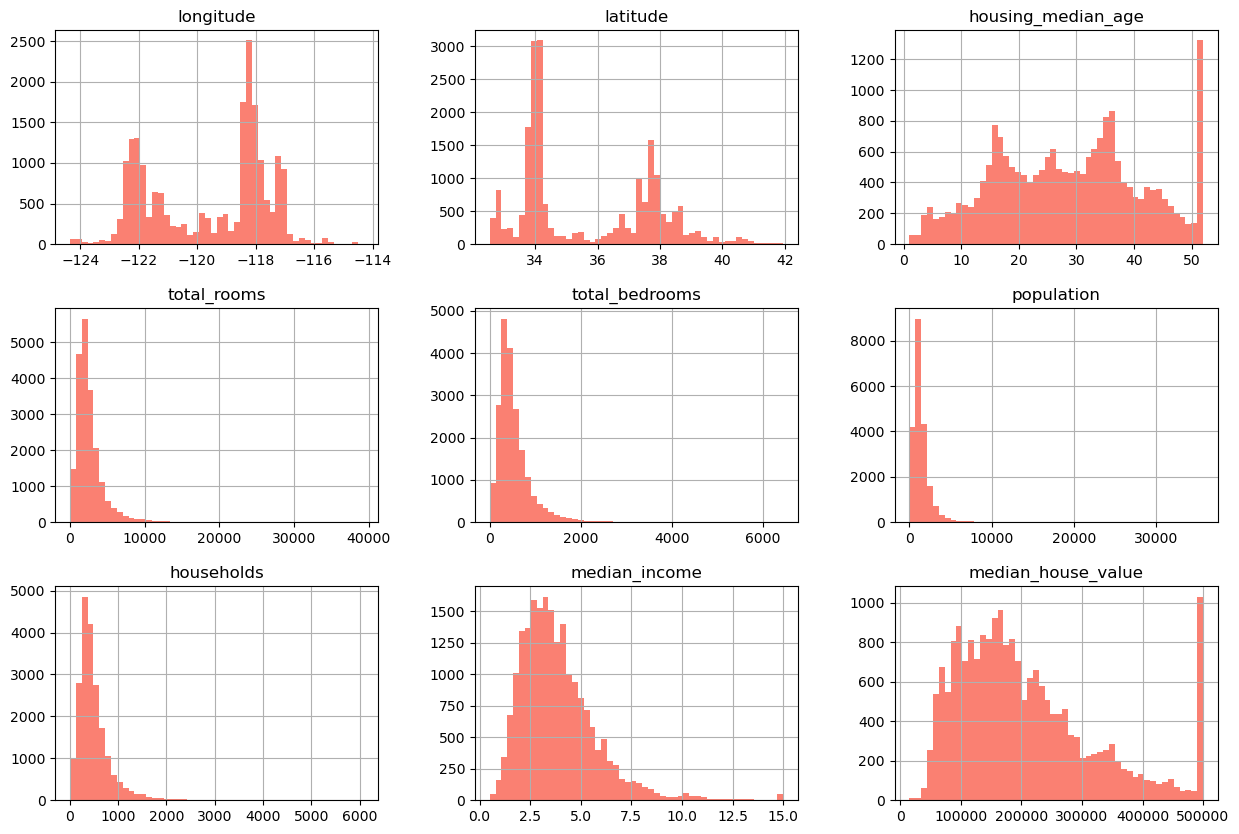

In [4]:
import matplotlib.pyplot as plt

df.hist(color = 'salmon',bins=50,figsize=(15,10))
plt.show()

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

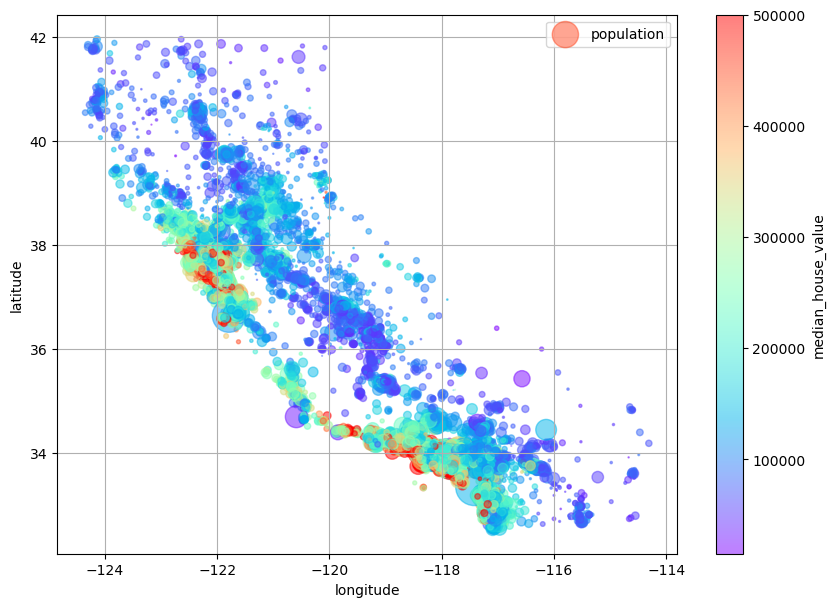

In [5]:
# data vizualisation
df.plot(kind="scatter", x="longitude", y="latitude", grid=True,alpha=0.5,
        
s=df["population"] / 50, label="population",

c="median_house_value", cmap="rainbow", colorbar=True,

legend=True, sharex=False, figsize=(10, 7))

In [6]:
# Correlation matrix

correlation_matrix = df.corr(numeric_only=True)
correlation_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [7]:
df["rooms_per_house"]=df["total_rooms"]/df["households"]
df["bedrooms_ratio"]= df["total_bedrooms"]/df["total_rooms"]
df["bedrooms_per_house"] = df ["total_bedrooms"]/df["households"]
df["people_per_house"]=df["population"]/df["households"]

In [8]:
correlation_matrix=df.corr()
correlation_matrix["median_house_value"].sort_values(ascending=False)

/tmp/ipykernel_177037/2097208488.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix=df.corr()


median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
bedrooms_per_house   -0.046739
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

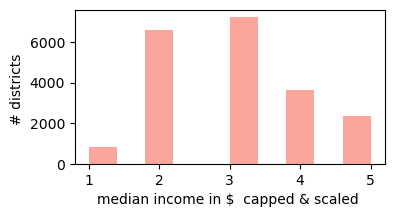

In [9]:
#stratified sampling : base on mediane_income which is an important attribute for the 
#median_house_value since the correlation is the highest

# create categories for the mediane income (how many have income in [0,1.5[, [1,5,3[ ...)
income_cat= pd.DataFrame(columns=['income_cat']) 
income_cat['income_cat']= pd.cut(df["median_income"],bins = [0,1.5,3,4.5,6,np.inf] , labels= [1,2,3,4,5])

income_cat["income_cat"].hist(color='salmon',figsize=(4,2),grid=False,alpha = 0.7)
plt.xlabel("median income in $  capped & scaled ")
plt.ylabel("# districts ")
plt.show()

In [10]:
# sampling based on stratify pd which is income_cat
from sklearn.model_selection import train_test_split
train_set , test_set = train_test_split(df,test_size=0.2,stratify=income_cat["income_cat"],random_state=42)


In [11]:
# from our train set we isolate the predictors (attributes used to predict) and the labels (what we want to predict)
# we do not modify the original train set by doing this !
predictors = train_set.drop('median_house_value',axis=1)
predictors_cp = predictors.copy()

labels = train_set["median_house_value"].copy()
labels_cp = labels.copy()

In [12]:
## Clean the data (IMPUTATION : replace nan values by the median)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

predictors_num = predictors.select_dtypes(include=[np.number])
print("Number of nan values in predictors_nu : ", predictors_num.isna().sum().sum())

# By appliying fit the imputer calculates the median of each attribute 
# and store in in imputer.statistics_
imputer.fit(predictors_num) 
# by appliying transform to the imputer we replace all the nan values by the meadian
predictors_num_imputed = imputer.transform(predictors_num)
predictors_num_imputed = pd.DataFrame(predictors_num_imputed,columns=predictors_num.columns,index = predictors_num.index)
print("Number of Nan values in predictors_num_imputed: ",predictors_num_imputed.isna().sum().sum())


Number of nan values in predictors_nu :  504
Number of Nan values in predictors_num_imputed:  0


In [13]:
predictors_cat = predictors[["ocean_proximity"]]
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
predictors_cat_1hot=cat_encoder.fit_transform(predictors_cat)
print(predictors_cat.index)
cat_encoder.get_feature_names_out()
predictors_cat_1hot = pd.DataFrame(predictors_cat_1hot.toarray,columns=cat_encoder.get_feature_names_out(),index = predictors_cat.index)
predictors_cat_1hot.info()

Int64Index([13096, 14973,  3785, 14689, 20507,  1286, 18078,  4396, 18031,
             6753,
            ...
            11877, 17004,  1894,  6234,  7071, 14207, 13105, 19301, 19121,
            19888],
           dtype='int64', length=16512)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ocean_proximity_<1H OCEAN   16512 non-null  object
 1   ocean_proximity_INLAND      16512 non-null  object
 2   ocean_proximity_ISLAND      16512 non-null  object
 3   ocean_proximity_NEAR BAY    16512 non-null  object
 4   ocean_proximity_NEAR OCEAN  16512 non-null  object
dtypes: object(5)
memory usage: 774.0+ KB


In [14]:
### Application of StandardScaler to our data 
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

predictors_num = std_scaler.fit_transform(predictors_num)

In [15]:
from sklearn.base import BaseEstimator ,TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans

# kmeans find 10 clusters centers by giving more weight to the attributes with higher sample_weight
# based on radial basis function (gaussian) we estimitate the similarities of the points
# to the clusters centers

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


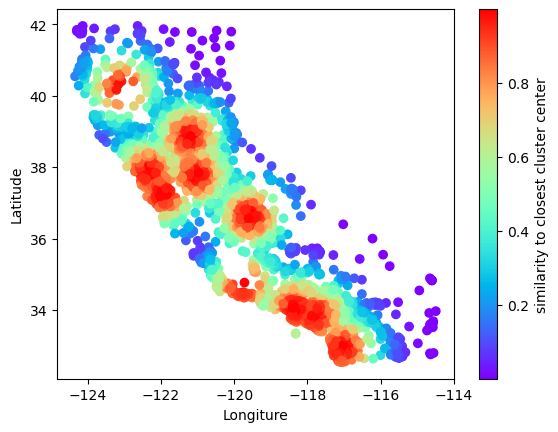

In [16]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(predictors[["latitude", "longitude"]],
sample_weight=labels)

clusters_labels= pd.DataFrame(cluster_simil.kmeans_.labels_,columns= ["labels"],index = predictors.index)
clusters_similarities = pd.DataFrame(similarities.max(axis=1),columns =["score"],index = predictors.index)
col_centroides = []
df_centroides = pd.DataFrame(cluster_simil.kmeans_.cluster_centers_,columns=["Xc","Yc"])
plt.scatter(x=predictors['longitude'],y=predictors['latitude'],
                c=clusters_similarities["score"], cmap="rainbow"
                
)
plt.xlabel("Longiture")
plt.ylabel("Latitude")

plt.colorbar(label = "similarity to closest cluster center")


plt.show()


In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
# pipeline to apply to numerical attributes, apply median strategy as imputer to get rid of nan values and standardscaler to scale the data
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

#pipeline to apply to categorical attributes apply most_frequent strategy  to get rid of nan values as imputer and OneHootEncoder 
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown="ignore"))


num_attribes = predictors.select_dtypes(include=[np.number]).columns
num_attribes
cat_atrtibs = ['ocean_proximity']

preprocessing = ColumnTransformer([('num',num_pipeline,num_attribes),('cat',cat_pipeline,cat_atrtibs)])


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# we create a pipeline lin_reg that will first apply transformations to our data which is defined by preprocessinf
# ten in apply the LinearRegression model 
lin_reg = make_pipeline(preprocessing,LinearRegression())
# we aplly it !

lin_reg.fit(predictors,labels)

house_price_prediction = lin_reg.predict(predictors)

lin_rmse = mean_squared_error(labels,house_price_prediction,squared=False)

print(f"The RMSE of The LinearRegression model is : ${lin_rmse} !")
print("The model underfit the data (intuition try to match hyperbolic curve with linear curve) !")

The RMSE of The LinearRegression model is : $67225.0219976014 !
The model underfit the data (intuition try to match hyperbolic curve with linear curve) !


In [19]:
# DecisionTreeRegressor : more caple of finding complex non-linear relationship in the data, Let's try it.

from sklearn.tree import DecisionTreeRegressor

decision_tree_regressor = make_pipeline(preprocessing,DecisionTreeRegressor(random_state=42))
decision_tree_regressor.fit(predictors,labels)
house_price_prediction = decision_tree_regressor.predict(predictors)
decision_tree_regressor_rmse = mean_squared_error(labels,house_price_prediction,squared=False)
print(f"The RMSE of The Decision Tree Regressor (DTR) is : ${decision_tree_regressor_rmse} !")
print("The model overfits the data (intuition uses all the points of the given curve to predict actual curve)"
      "\n"
      "By testing it on the test set we may have huge RMSE !")


The RMSE of The Decision Tree Regressor (DTR) is : $0.0 !
The model overfits the data (intuition uses all the points of the given curve to predict actual curve)
By testing it on the test set we may have huge RMSE !


In [20]:
print("To really test the Decision Tree Regressor model,\n"
      "We can split the training set into smaller training sets and evaluate the results against the validation set!")

print("\nScikit-Learn 'k-fold cross validation' allows us to do that !")

To really test the Decision Tree Regressor model,
We can split the training set into smaller training sets and evaluate the results against the validation set!

Scikit-Learn 'k-fold cross validation' allows us to do that !


In [21]:
print("The 'k-fold cross validation' randomly split the training set into k non-overlapping subsets 'folds'\n"
      "Then it trains and evaluates the DTM k times picking a different fold for evaluation every time and using the (k-1) remaining folds for training \n")

The 'k-fold cross validation' randomly split the training set into k non-overlapping subsets 'folds'
Then it trains and evaluates the DTM k times picking a different fold for evaluation every time and using the (k-1) remaining folds for training 



In [22]:
from sklearn.model_selection import cross_val_score

# - sign since it uses a utility function instead of a cost function, it maximises instead of minimizing 
# the scoring is the opposite of the rms2
cross_val_tree_rmse = -cross_val_score(decision_tree_regressor,predictors,labels,scoring="neg_root_mean_squared_error",cv = 10)

pd_cross_val_tree_rmse = pd.Series(cross_val_tree_rmse)

print(f"The mean value ofthe k-fold cross validation DTM RMSE is :  ${pd_cross_val_tree_rmse.mean()}")


The mean value ofthe k-fold cross validation DTM RMSE is :  $70669.05311064154


In [23]:
## Random Forest Regressor
print("The Random Forest Regressor (RFR) works by training many desicion trees on random subsets of the features.\n"
      "Then it averages their predictions, such models are called 'Ensembles' ")
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor = make_pipeline(preprocessing,RandomForestRegressor(random_state=42))

random_forest_rmse = - cross_val_score(random_forest_regressor,predictors,labels,scoring='neg_root_mean_squared_error',cv = 10)

pd_random_forest_rmse = pd.Series(random_forest_rmse)

The Random Forest Regressor (RFR) works by training many desicion trees on random subsets of the features.
Then it averages their predictions, such models are called 'Ensembles' 


In [24]:

print(f"The RMSE of The Random Tree Regressor (RTR) is : ${pd_random_forest_rmse.mean()} !"
      "\nThat's better than Linear Regression, Decision Tree and k-folds cross validation DT !")

The RMSE of The Random Tree Regressor (RTR) is : $49841.507819068356 !
That's better than Linear Regression, Decision Tree and k-folds cross validation DT !


**PART 2**
*   Put every processing of the dataframe in prepocessing and apply it when we apply
        our model

In [25]:
# we will do everythiong in another way by putting all the transformation  in the df
# in the processing process
from sklearn.model_selection import train_test_split
train_set , test_set = train_test_split(df_cp,test_size=0.2,stratify=income_cat["income_cat"],random_state=42)


In [26]:
# from our train set we isolate the predictors (attributes used to predict) and the labels (what we want to predict)
# we do not modify the original train set by doing this !
predictors = train_set.drop('median_house_value',axis=1)
labels = train_set["median_house_value"].copy()


**PREPROCESSING**

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector

def column_ratio(X):
    # X is a list containg columns of dataframe for which we want to compute the ratio
    return X[:,[0]]/X[:,[1]]

def ratio_name(function_transformer,features_names_in):
    #return ratio string
    return["ratio"]
def ratio_pipeline():
    # the pipeline for the ratio columns
    return make_pipeline(SimpleImputer(strategy="median"),FunctionTransformer(column_ratio,feature_names_out=ratio_name),StandardScaler())

# pipeline that computes the logarithm of the concerned columns
log_pipeline = make_pipeline(SimpleImputer(strategy="median"),FunctionTransformer(np.log,feature_names_out="one-to-one"),StandardScaler())
# default pipeline to apply to numerical attributes
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())
# pipeline to apply to categorical attributes
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown="ignore"))
# definition of the preprocessing
preprocessing  = ColumnTransformer([("bedrooms",ratio_pipeline(),["total_bedrooms","total_rooms"]),
                                     ("rooms_per_house",ratio_pipeline(),["total_rooms","households"]),
                                     ("people_per_house",ratio_pipeline(),["population","households"]),
                                     ("log",log_pipeline,["total_bedrooms","total_rooms","population",
                                                            "households","median_income"]),
                                    ("geo",cluster_simil,["latitude","longitude"]),
                                    ("cat",cat_pipeline,make_column_selector(dtype_include=object))
                                    ],
                                    remainder=default_num_pipeline)


In [28]:
predictors_processed = preprocessing.fit_transform(predictors)
predictors_processed.shape
preprocessing.get_feature_names_out()

/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
linear_regressor = make_pipeline(preprocessing,LinearRegression())
linear_regressor.fit(predictors,labels)
price_predictions = linear_regressor.predict(predictors)

linear_regressor_rmse = mean_squared_error(labels,price_predictions,squared=False)
print(f"The RMSE of The LinearRegression model is : ${linear_regressor_rmse} !")
print("The model underfit the data (intuition try to match hyperbolic curve with linear curve) !")


/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The RMSE of The LinearRegression model is : $68687.89176590041 !
The model underfit the data (intuition try to match hyperbolic curve with linear curve) !


In [30]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_regressor = make_pipeline(preprocessing,DecisionTreeRegressor(random_state=42))
decision_tree_regressor.fit(predictors,labels)
price_predictions = decision_tree_regressor.predict(predictors)
decision_tree_regressor_rmse = mean_squared_error(labels,price_predictions,squared=False)

print(f"The RMSE of The Decision Tree Regressor (DTR) is : ${decision_tree_regressor_rmse} !")
print("The model overfits the data (intuition uses all the points of the given curve to predict actual curve)"
      "\n"
      "By testing it on the test set we may have huge RMSE !")




/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The RMSE of The Decision Tree Regressor (DTR) is : $0.0 !
The model overfits the data (intuition uses all the points of the given curve to predict actual curve)
By testing it on the test set we may have huge RMSE !


In [31]:
# k-cross validation decision tree

from sklearn.model_selection import cross_val_score
k_cross_validation_decision_tree_regressor = -cross_val_score(decision_tree_regressor,predictors,labels,scoring="neg_root_mean_squared_error",cv=10)

k_cross_validation_decision_tree_regressor_rmse = pd.Series(k_cross_validation_decision_tree_regressor).mean()

print(f"The mean value ofthe k-fold cross validation DTM RMSE is :  ${k_cross_validation_decision_tree_regressor_rmse}")

/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.loc

The mean value ofthe k-fold cross validation DTM RMSE is :  $66868.02728758389


In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor = make_pipeline(preprocessing,RandomForestRegressor(random_state=42))

random_forest_rmse = -cross_val_score(random_forest_regressor,predictors,labels,scoring = "neg_root_mean_squared_error",cv = 10)

random_forest_rmse = pd.Series(random_forest_rmse).mean()

print(f"The RMSE of The Random Tree Regressor (RTR) is : ${random_forest_rmse} !"
      "\nThat's better than Linear Regression, Decision Tree and k-folds cross validation DT !")

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


pipeline = Pipeline([("preprocessing",preprocessing),
                     ("random_forest", RandomForestRegressor(random_state=42))])

param_grid = [
    {'preprocessing__geo__n_clusters' : [5,8,10],
     'random_forest__max_features':[4,6,8]},
     {'preprocessing__geo__n_clusters':[4,6,8],
      'random_forest__max_features':[6,8,10]}
]

grid_search = GridSearchCV(pipeline,param_grid,cv=3,scoring= 'neg_root_mean_squared_error')

grid_search.fit(predictors,labels)




/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.loc

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f78985530d0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [4, 6, 8],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [34]:
grid_search.best_params_
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(by="mean_test_score",ascending=False,inplace = True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,7.546969,0.491138,0.180834,0.014667,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44683.355320,-44654.825561,-45657.384730,-44998.521871,466.031964,1
6,5.972999,0.910101,0.181271,0.004354,10,4,"{'preprocessing__geo__n_clusters': 10, 'random...",-44556.999144,-44883.889914,-45831.011039,-45090.633365,540.267661,2
4,7.809110,0.418640,0.196425,0.018011,8,6,"{'preprocessing__geo__n_clusters': 8, 'random_...",-45200.755429,-44969.179679,-46101.731945,-45423.889017,488.542122,3
15,6.852700,0.319246,0.167862,0.001612,8,6,"{'preprocessing__geo__n_clusters': 8, 'random_...",-45200.755429,-44969.179679,-46101.731945,-45423.889017,488.542122,3
8,8.270394,0.320017,0.168813,0.003565,10,8,"{'preprocessing__geo__n_clusters': 10, 'random...",-45191.511586,-45212.152116,-45992.842490,-45465.502064,372.981190,5


In [35]:
# randomized search

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
'random_forest__max_features': randint(low=2, high=20)}
rnd_search = RandomizedSearchCV( pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(predictors, labels)

/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/quantoums/.loc

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f7896ad2cd0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f7896b11990>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [36]:
final_model =rnd_search.best_estimator_ #includes preprocessing
# add any other model in pipeline if we want to compare
features_importances = final_model["random_forest"].feature_importances_
# let's see the most important parameters of our model
sorted(zip(features_importances,final_model["preprocessing"].get_feature_names_out()),reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__Cluster 0 similarity'),
 (0.02879263999929514, 'geo__Cluster 28 similarity'),
 (0.023530192521380392, 'geo__Cluster 24 similarity'),
 (0.020544786346378206, 'geo__Cluster 27 similarity'),
 (0.019873052631077512, 'geo__Cluster 43 similarity'),
 (0.018597511022930273, 'geo__Cluster 34 similarity'),
 (0.017409085415656868, 'geo__Cluster 37 similarity'),
 (0.015546519677632162, 'geo__Cluster 20 similarity'),
 (0.014230331127504292, 'geo__Cluster 17 similarity'),
 (0.0141032216204026, 'geo__Cluster 39 similarity'),
 (0.014065768027447325, 'geo__Cluster 9 similarity'),
 (0.01354220782825315, 'geo__Cluster 4 similarity'),
 (0.01348963625822907, 'geo__Cluster 3 similarity'),
 (0.01338319626383868, 'geo__Cluster 38 similarity'

In [37]:
##Evaluate model on Test set

X_test = test_set.drop("median_house_value",axis=1)
y_test = test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test,final_predictions,squared=False)

print("The final RMSE for The best model (RTR) is : $",final_rmse)

The final RMSE for The best model (RTR) is : $ 41424.40026462184


In [38]:
# save our model

import joblib

#joblib.dump(final_model,"californian_house_price_predictor.pkl")

# after it has been save etc if we want to use it use joblib.load and define all customs classes used and import all
# libraries used